# Model a Galaxy Cluster

## Notebook for generating an example galaxy cluster model. 

This notebook goes through the steps to generate model data for galaxy cluster weak lensing observables.  In particular, we define a galaxy cluster model that follows and NFW distribution and generate various profiles for the model (mass density, convergence, shear, etc.), which we plot.  Note, a full pipeline to measure a galaxy cluster weak lensing mass requires fitting the observed (or mock) data to a model.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Imports specific to clmm 

In [2]:
import clmm
import clmm.theory as m
from clmm import Cosmology

Make sure we know which version we're using

In [3]:
clmm.__version__

'0.9.0'

Define a cosmology using astropy

In [4]:
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

Define the galaxy cluster model.  Here, we choose parameters that describe the galaxy cluster model, including the mass definition, concentration, and mass distribution.  For the mass distribution, we choose a distribution that follows an NFW profile.

In [5]:
density_profile_parametrization = 'nfw'
mass_Delta = 200
cluster_mass = 1.e15
cluster_concentration = 4
z_cl = 1.
z_source = 2.

Quick test of all theory functionality

In [6]:
r3d = np.logspace(-2, 2, 100)

In [7]:
rho = m.compute_3d_density(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                       z_cl=z_cl, cosmo=cosmo)

In [8]:
Sigma = m.compute_surface_density(r3d, cluster_mass, cluster_concentration, z_cl, cosmo=cosmo, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model=density_profile_parametrization)

In [9]:
DeltaSigma = m.compute_excess_surface_density(r3d, cluster_mass, cluster_concentration, z_cl, cosmo=cosmo, 
                                              delta_mdef=mass_Delta, 
                                              halo_profile_model=density_profile_parametrization)

In [10]:
Sigmac = m.compute_critical_surface_density(cosmo, z_cluster=z_cl, z_source=z_source)

In [11]:
gammat = m.compute_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, z_cluster=z_cl, 
                                    z_source=z_source, cosmo=cosmo, delta_mdef=mass_Delta, 
                                    halo_profile_model=density_profile_parametrization, 
                                    z_src_model='single_plane')

In [12]:
kappa = m.compute_convergence(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cl, z_source=z_source,
                               cosmo=cosmo, delta_mdef=mass_Delta, 
                               halo_profile_model=density_profile_parametrization, 
                               z_src_model='single_plane')

In [13]:
gt = m.compute_reduced_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                        z_cluster=z_cl, z_source=z_source, cosmo=cosmo, 
                                        delta_mdef=mass_Delta, 
                                        halo_profile_model=density_profile_parametrization, 
                                        z_src_model='single_plane')
        

In [14]:
mu = m.compute_magnification(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                        z_cluster=z_cl, z_source=z_source, cosmo=cosmo, 
                                        delta_mdef=mass_Delta, 
                                        halo_profile_model=density_profile_parametrization, 
                                        z_src_model='single_plane')


Plot the predicted profiles

In [15]:
def plot_profile(r, profile_vals, profile_label='rho'):
    plt.loglog(r, profile_vals)
    plt.xlabel('r [Mpc]', fontsize='xx-large')
    plt.ylabel(profile_label, fontsize='xx-large')

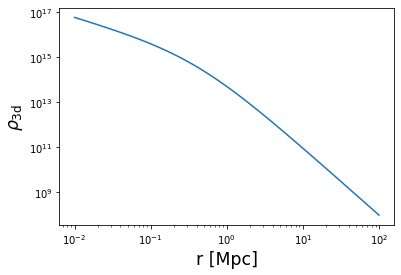

In [16]:
plot_profile(r3d, rho, '$\\rho_{\\rm 3d}$')

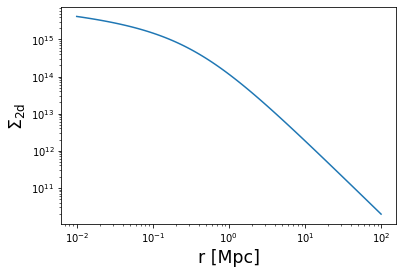

In [17]:
plot_profile(r3d, Sigma, '$\\Sigma_{\\rm 2d}$')

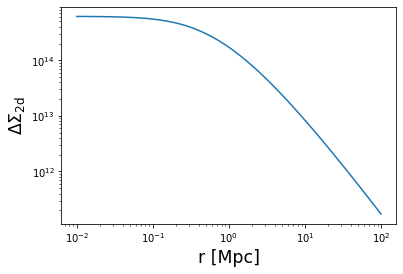

In [18]:
plot_profile(r3d, DeltaSigma, '$\\Delta\\Sigma_{\\rm 2d}$')

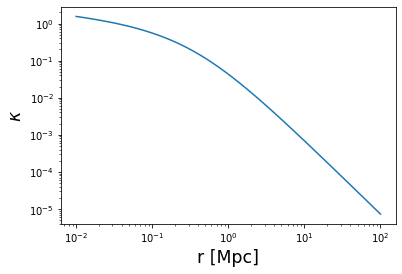

In [19]:
plot_profile(r3d, kappa, '$\\kappa$')

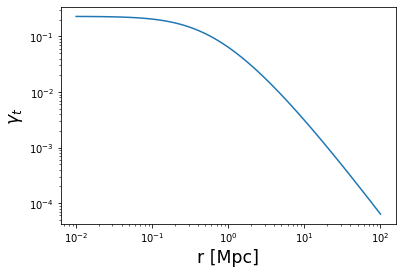

In [20]:
plot_profile(r3d, gammat, '$\\gamma_t$')

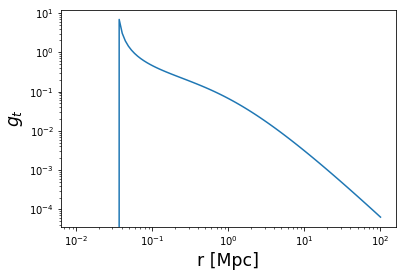

In [21]:
plot_profile(r3d, gt, '$g_t$')

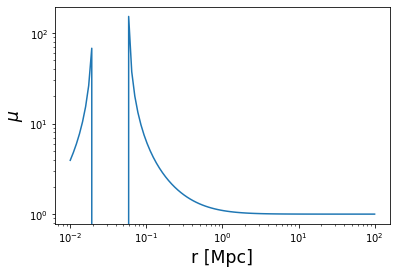

In [22]:
plot_profile(r3d, mu, '$\mu$')